Acknowledgment to the poster of this data set. Username 'fedesoriano' from [Kaggle.com](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset)

In [183]:
import pandas as pd
import seaborn as sns
import numpy as np
import category_encoders as ce
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, f1_score, plot_confusion_matrix, accuracy_score, precision_score, recall_score

In [184]:
df = pd.read_csv('PredictStrokes/healthcare-dataset-stroke-data.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [185]:
#This is just to rename the columns because I don't like underscores
df = df.rename(columns = {'heart_disease': 'heartDisease'})
df = df.rename(columns = {'ever_married': 'everMarried'})
df = df.rename(columns = {'work_type': 'workType'})
df = df.rename(columns = {'Residence_type': 'residenceType'})
df = df.rename(columns = {'avg_glucose_level': 'avgGlucoseLevel'})
df = df.rename(columns = {'smoking_status': 'smokingStatus'})

In [186]:
len(df['id'])

5110

## First look at the data
First thing I noticed is that this data set seem pretty small. 5,110 records. I don't have much room to remove data so I'll need to avoid that as much as possible.

Let's check for anything that might cause problems in our data.

In [187]:
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heartDisease         0
everMarried          0
workType             0
residenceType        0
avgGlucoseLevel      0
bmi                201
smokingStatus        0
stroke               0
dtype: int64

In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               5110 non-null   int64  
 1   gender           5110 non-null   object 
 2   age              5110 non-null   float64
 3   hypertension     5110 non-null   int64  
 4   heartDisease     5110 non-null   int64  
 5   everMarried      5110 non-null   object 
 6   workType         5110 non-null   object 
 7   residenceType    5110 non-null   object 
 8   avgGlucoseLevel  5110 non-null   float64
 9   bmi              4909 non-null   float64
 10  smokingStatus    5110 non-null   object 
 11  stroke           5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [189]:
df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [190]:
df['everMarried'].value_counts()

Yes    3353
No     1757
Name: everMarried, dtype: int64

In [191]:
df['workType'].value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: workType, dtype: int64

In [192]:
df['residenceType'].value_counts()

Urban    2596
Rural    2514
Name: residenceType, dtype: int64

In [193]:
df['smokingStatus'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smokingStatus, dtype: int64

In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               5110 non-null   int64  
 1   gender           5110 non-null   object 
 2   age              5110 non-null   float64
 3   hypertension     5110 non-null   int64  
 4   heartDisease     5110 non-null   int64  
 5   everMarried      5110 non-null   object 
 6   workType         5110 non-null   object 
 7   residenceType    5110 non-null   object 
 8   avgGlucoseLevel  5110 non-null   float64
 9   bmi              4909 non-null   float64
 10  smokingStatus    5110 non-null   object 
 11  stroke           5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Here are some places where I see some problems.
 - BMI has 201 records with missing info.
 - gender, hypertension, heartDisease, everMarried, residenceType, and stroke look like their a bianary classification. Simply a 'yes' or 'no' answer. No reason we can't make it a '1' or a '0'
 - workType and smokingStatus seems to be broken up into categories. I see no reason why we couldn't use a category encoder.
 - 'id' may cause noise in our data so let's remove that column to avoid it.

## Cleaning the data
Let's go through each one and start to solve the problems that come up, starting with dealing with the NaN values in BMI. Our records only have about 5,000 records to start with so removing 201 records is a lot of data being removed. The safest thing to do without swkeing the data is to take an average of everything in this column and fill in the NaN's with the average.

In [195]:
df = df.fillna(df.mean())
df.isna().sum()

id                 0
gender             0
age                0
hypertension       0
heartDisease       0
everMarried        0
workType           0
residenceType      0
avgGlucoseLevel    0
bmi                0
smokingStatus      0
stroke             0
dtype: int64

Sweet. Simple and clean, like my favorite song. Next, let's deal with the columns that could be a binary answer. Since hyptertension, heartDisease, and stroke are already binary 1's and 0's we can leave them alone. Let's deal with gender and everMarried

In [196]:
df

,id,gender,age,hypertension,heartDisease,everMarried,workType,residenceType,avgGlucoseLevel,bmi,smokingStatus,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,28.893237,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0


In [197]:
#These are the lists vlaues we want replaced
genderList = ['Male', 'Female']
marriedList = ['No', 'Yes']
residenceList = ['Urban', 'Rural']

In [198]:
#This function takes in a list of old values to find,
# and the specific column name we wish to apply this function to.
#What it returns is the modified df with the column was spcified,
#turned into a binary classification.

def makeBinary(oldList, columnName):
    binaryList = [0, 1]
    newVals = dict(zip(oldList, binaryList))
    return df[columnName].replace(newVals, inplace = True)

makeBinary(genderList, 'gender')

In [199]:
df['gender'].value_counts()

1        2994
0        2115
Other       1
Name: gender, dtype: int64

Shoots, almost. We missed one. Fortunately, removing one row isn't that big a deal, let's just drop them.

In [200]:
df.drop(df[df['gender'] == 'Other'].index, inplace = True)

In [201]:
df['gender'].value_counts()

1    2994
0    2115
Name: gender, dtype: int64

Success! Next is married. Second verse, same as the first. We'll apply the makeBinary function to the everMarried column the same way, with the marriedList we set aside earlier.

In [202]:
makeBinary(marriedList, 'everMarried')

In [203]:
df

,id,gender,age,hypertension,heartDisease,everMarried,workType,residenceType,avgGlucoseLevel,bmi,smokingStatus,stroke
0,9046,0,67.0,0,1,1,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,1,61.0,0,0,1,Self-employed,Rural,202.21,28.893237,never smoked,1
2,31112,0,80.0,0,1,1,Private,Rural,105.92,32.500000,never smoked,1
3,60182,1,49.0,0,0,1,Private,Urban,171.23,34.400000,smokes,1
4,1665,1,79.0,1,0,1,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,1,80.0,1,0,1,Private,Urban,83.75,28.893237,never smoked,0
5106,44873,1,81.0,0,0,1,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,19723,1,35.0,0,0,1,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,37544,0,51.0,0,0,1,Private,Rural,166.29,25.600000,formerly smoked,0


In [204]:
df['everMarried'].value_counts()

1    3353
0    1756
Name: everMarried, dtype: int64

In [205]:
makeBinary(residenceList, 'residenceType')

In [206]:
df['residenceType'].value_counts()

0    2596
1    2513
Name: residenceType, dtype: int64

Success again! Lastly, let's drop 'id' and let's move on to starting our model!

In [207]:
df.drop(['id'], axis = 1)

,gender,age,hypertension,heartDisease,everMarried,workType,residenceType,avgGlucoseLevel,bmi,smokingStatus,stroke
0,0,67.0,0,1,1,Private,0,228.69,36.600000,formerly smoked,1
1,1,61.0,0,0,1,Self-employed,1,202.21,28.893237,never smoked,1
2,0,80.0,0,1,1,Private,1,105.92,32.500000,never smoked,1
3,1,49.0,0,0,1,Private,0,171.23,34.400000,smokes,1
4,1,79.0,1,0,1,Self-employed,1,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,1,80.0,1,0,1,Private,0,83.75,28.893237,never smoked,0
5106,1,81.0,0,0,1,Self-employed,0,125.20,40.000000,never smoked,0
5107,1,35.0,0,0,1,Self-employed,1,82.99,30.600000,never smoked,0
5108,0,51.0,0,0,1,Private,1,166.29,25.600000,formerly smoked,0


# Step 1: Testing different model types
In this section we'll test and fit a number of different models onto our data to see which one's make the most sense and give us the best predictions in our results. We're not just looking at how good our scores are but how accurate our models are from the start.

**Note:** When we start to look at our model, 0's will represent a "No" meaning "This patient has *not* had a stroke before."

1's will represent "Yes" meaning "This patient *has* had a stroke before.

In [208]:
df

,id,gender,age,hypertension,heartDisease,everMarried,workType,residenceType,avgGlucoseLevel,bmi,smokingStatus,stroke
0,9046,0,67.0,0,1,1,Private,0,228.69,36.600000,formerly smoked,1
1,51676,1,61.0,0,0,1,Self-employed,1,202.21,28.893237,never smoked,1
2,31112,0,80.0,0,1,1,Private,1,105.92,32.500000,never smoked,1
3,60182,1,49.0,0,0,1,Private,0,171.23,34.400000,smokes,1
4,1665,1,79.0,1,0,1,Self-employed,1,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,1,80.0,1,0,1,Private,0,83.75,28.893237,never smoked,0
5106,44873,1,81.0,0,0,1,Self-employed,0,125.20,40.000000,never smoked,0
5107,19723,1,35.0,0,0,1,Self-employed,1,82.99,30.600000,never smoked,0
5108,37544,0,51.0,0,0,1,Private,1,166.29,25.600000,formerly smoked,0


In [209]:
#Data Prep

#Scales my data
scaler = StandardScaler()
#Ecoder to categorize onto cols 'workType' and 'smokingStatus'
encoder = ce.CountEncoder(cols = ['workType', 'smokingStatus'])

xCols = [c for c in df.columns.to_list() if c not in ['stroke']]

x = df[xCols]
y = df['stroke']

xTrain, xTest, yTrain, yTest = train_test_split(
    x, y, test_size=0.33, random_state=42)

xTrainEncoded = encoder.fit_transform(xTrain)
xTestEncoded = encoder.transform(xTest)

xTrainScaled = scaler.fit_transform(xTrainEncoded)
xTestScaled = scaler.transform(xTestEncoded)

C:\Users\jpake\anaconda3\envs\learn-env\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Accuracy Train Score: 0.7449605609114811
Accuracy Test Score: 0.7313167259786477
-----
F1-Train Score: 0.22399999999999998
F1-Test Score: 0.24625623960066553
-----
Precision Train Score: 0.12962962962962962
Precision Test Score: 0.14653465346534653
-----
Recall Train Score: 0.7449605609114811
Recall Test Score: 0.7313167259786477


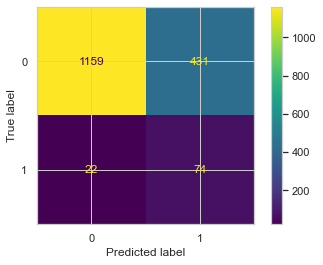

In [210]:
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression(random_state = 123, class_weight = 'balanced')
logReg.fit(xTrainScaled, yTrain)

yPredTrain = logReg.predict(xTrainScaled)
yPredTest = logReg.predict(xTestScaled)

plot_confusion_matrix(logReg, xTestScaled, yTest)

print(f"Accuracy Train Score: {accuracy_score(yTrain, yPredTrain)}")
print(f"Accuracy Test Score: {accuracy_score(yTest, yPredTest)}")
print('-----')
print(f"F1-Train Score: {f1_score(yTrain, yPredTrain)}")
print(f"F1-Test Score: {f1_score(yTest, yPredTest)}")
print('-----')
print(f"Precision Train Score: {precision_score(yTrain, yPredTrain)}")
print(f"Precision Test Score: {precision_score(yTest, yPredTest)}")
print('-----')
print(f"Recall Train Score: {recall_score(yTrain, yPredTrain, average='weighted')}")
print(f"Recall Test Score: {recall_score(yTest, yPredTest, average='weighted')}")

Accuracy Train Score: 0.8317265556529361
Accuracy Test Score: 0.7906287069988137
-----
F1-Train Score: 0.32710280373831774
F1-Test Score: 0.23427331887201736
-----
Precision Train Score: 0.19914651493598862
Precision Test Score: 0.14794520547945206
-----
Recall Train Score: 0.8317265556529361
Recall Test Score: 0.7906287069988137


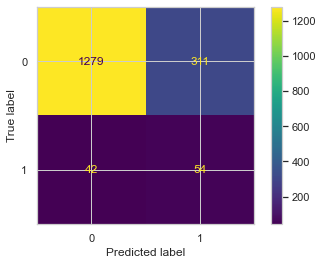

In [211]:
from sklearn.svm import SVC

clf = SVC(random_state=0, class_weight = 'balanced')
clf.fit(xTrainScaled, yTrain)

yPredTrain = clf.predict(xTrainScaled)
yPredTest = clf.predict(xTestScaled)

plot_confusion_matrix(clf, xTestScaled, yTest)

print(f"Accuracy Train Score: {accuracy_score(yTrain, yPredTrain)}")
print(f"Accuracy Test Score: {accuracy_score(yTest, yPredTest)}")
print('-----')
print(f"F1-Train Score: {f1_score(yTrain, yPredTrain)}")
print(f"F1-Test Score: {f1_score(yTest, yPredTest)}")
print('-----')
print(f"Precision Train Score: {precision_score(yTrain, yPredTrain)}")
print(f"Precision Test Score: {precision_score(yTest, yPredTest)}")
print('-----')
print(f"Recall Train Score: {recall_score(yTrain, yPredTrain, average='weighted')}")
print(f"Recall Test Score: {recall_score(yTest, yPredTest, average='weighted')}")

Accuracy Train Score: 0.8735027753432661
Accuracy Test Score: 0.8600237247924081
-----
F1-Train Score: 0.21129326047358835
F1-Test Score: 0.25316455696202533
-----
Average Precision Train Score: 0.14646464646464646
Average Precision Test Score: 0.18181818181818182
-----
Recall Train Score: 0.8735027753432661
Recall Test Score: 0.8600237247924081


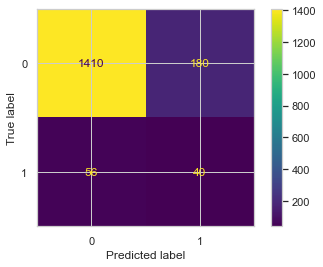

In [212]:
from sklearn.naive_bayes import GaussianNB

gauNB = GaussianNB()
gauNB.fit(xTrainScaled, yTrain)

yPredTrain = gauNB.predict(xTrainScaled)
yPredTest = gauNB.predict(xTestScaled)

plot_confusion_matrix(gauNB, xTestScaled, yTest)

print(f"Accuracy Train Score: {accuracy_score(yTrain, yPredTrain)}")
print(f"Accuracy Test Score: {accuracy_score(yTest, yPredTest)}")
print('-----')
print(f"F1-Train Score: {f1_score(yTrain, yPredTrain)}")
print(f"F1-Test Score: {f1_score(yTest, yPredTest)}")
print('-----')
print(f"Average Precision Train Score: {precision_score(yTrain, yPredTrain)}")
print(f"Average Precision Test Score: {precision_score(yTest, yPredTest)}")
print('-----')
print(f"Recall Train Score: {recall_score(yTrain, yPredTrain, average='weighted')}")
print(f"Recall Test Score: {recall_score(yTest, yPredTest, average='weighted')}")

In [213]:
df.value_counts('stroke')

stroke
0    4860
1     249
dtype: int64

In [214]:
#XGBClassifier doesn't have a function to automatically balance imbalanced
#datasets so we need to find out what number to give as the weight.
#scale_pos_weight = total_negative_examples (not stroke) / total_positive_examples (stroke)
4860/249

19.518072289156628

Accuracy Train Score: 0.9997078586035641
Accuracy Test Score: 0.9317912218268091
-----
F1-Train Score: 0.9967426710097721
F1-Test Score: 0.21768707482993196
-----
Average Precision Train Score: 0.9935064935064936
Average Precision Test Score: 0.3137254901960784
-----
Recall Train Score: 0.9997078586035641
Recall Test Score: 0.9317912218268091


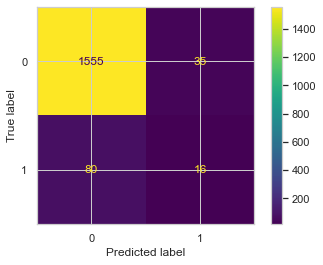

In [215]:
import xgboost as xgb
xgbClass = xgb.XGBClassifier(scale_pos_weight = 19.518072289156628)

xgbClass.fit(xTrainScaled, yTrain)

yPredTrain = xgbClass.predict(xTrainScaled)
yPredTest = xgbClass.predict(xTestScaled)

plot_confusion_matrix(xgbClass, xTestScaled, yTest)

print(f"Accuracy Train Score: {accuracy_score(yTrain, yPredTrain)}")
print(f"Accuracy Test Score: {accuracy_score(yTest, yPredTest)}")
print('-----')
print(f"F1-Train Score: {f1_score(yTrain, yPredTrain)}")
print(f"F1-Test Score: {f1_score(yTest, yPredTest)}")
print('-----')
print(f"Average Precision Train Score: {precision_score(yTrain, yPredTrain)}")
print(f"Average Precision Test Score: {precision_score(yTest, yPredTest)}")
print('-----')
print(f"Recall Train Score: {recall_score(yTrain, yPredTrain, average='weighted')}")
print(f"Recall Test Score: {recall_score(yTest, yPredTest, average='weighted')}")

Accuracy Train Score: 1.0
Accuracy Test Score: 0.905693950177936
-----
F1-Train Score: 1.0
F1-Test Score: 0.11173184357541899
-----
Average Precision Train Score: 1.0
Average Precision Test Score: 0.12048192771084337
-----
Recall Train Score: 1.0
Recall Test Score: 0.905693950177936


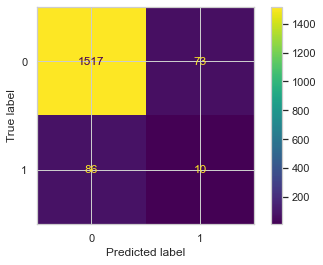

In [216]:
from sklearn.tree import DecisionTreeClassifier
decTree = DecisionTreeClassifier(class_weight='balanced')

decTree.fit(xTrainScaled, yTrain)

yPredTrain = decTree.predict(xTrainScaled)
yPredTest = decTree.predict(xTestScaled)

plot_confusion_matrix(decTree, xTestScaled, yTest)

print(f"Accuracy Train Score: {accuracy_score(yTrain, yPredTrain)}")
print(f"Accuracy Test Score: {accuracy_score(yTest, yPredTest)}")
print('-----')
print(f"F1-Train Score: {f1_score(yTrain, yPredTrain)}")
print(f"F1-Test Score: {f1_score(yTest, yPredTest)}")
print('-----')
print(f"Average Precision Train Score: {precision_score(yTrain, yPredTrain)}")
print(f"Average Precision Test Score: {precision_score(yTest, yPredTest)}")
print('-----')
print(f"Recall Train Score: {recall_score(yTrain, yPredTrain, average='weighted')}")
print(f"Recall Test Score: {recall_score(yTest, yPredTest, average='weighted')}")

Accuracy Train Score: 1.0
Accuracy Test Score: 0.9430604982206405
-----
F1-Train Score: 1.0
F1-Test Score: 0.0
-----
Average Precision Train Score: 1.0
Average Precision Test Score: 0.0
-----
Recall Train Score: 1.0
Recall Test Score: 0.9430604982206405


C:\Users\jpake\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


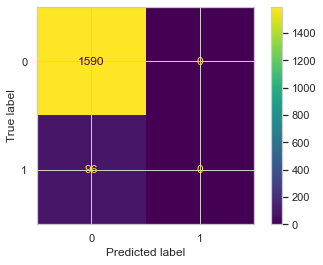

In [217]:
from sklearn.ensemble import RandomForestClassifier
rngForest = RandomForestClassifier(class_weight='balanced')

rngForest.fit(xTrainScaled, yTrain)

yPredTrain = rngForest.predict(xTrainScaled)
yPredTest = rngForest.predict(xTestScaled)

plot_confusion_matrix(rngForest, xTestScaled, yTest)

print(f"Accuracy Train Score: {accuracy_score(yTrain, yPredTrain)}")
print(f"Accuracy Test Score: {accuracy_score(yTest, yPredTest)}")
print('-----')
print(f"F1-Train Score: {f1_score(yTrain, yPredTrain)}")
print(f"F1-Test Score: {f1_score(yTest, yPredTest)}")
print('-----')
print(f"Average Precision Train Score: {precision_score(yTrain, yPredTrain)}")
print(f"Average Precision Test Score: {precision_score(yTest, yPredTest)}")
print('-----')
print(f"Recall Train Score: {recall_score(yTrain, yPredTrain, average='weighted')}")
print(f"Recall Test Score: {recall_score(yTest, yPredTest, average='weighted')}")

It looks like RandomForestClassifier wins it. Though this

# Model 2: Commitment to RandomForestClassifier

Time for feature engineering with RandomForestClassifier! Let's make a second model for this and name it something different for, just for the sake of oganization.

Accuracy Train Score: 0.7487583990651475
Accuracy Test Score: 0.7449584816132859
-----
F1-Train Score: 0.21245421245421245
F1-Test Score: 0.2456140350877193
-----
Average Precision Train Score: 0.1235356762513312
Average Precision Test Score: 0.14767932489451477
-----
Recall Train Score: 0.7487583990651475
Recall Test Score: 0.7449584816132859


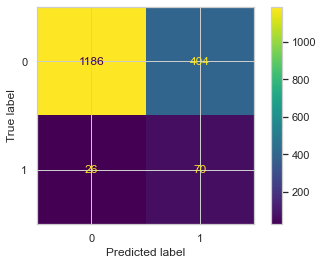

In [218]:
rngForest2 = RandomForestClassifier(class_weight='balanced',
                                    max_depth=None,
                                    n_estimators=100,
                                    min_samples_split=20,
                                    min_samples_leaf=20,
                                    min_weight_fraction_leaf=0.497,
                                    random_state = 123,
                                    max_features = 'auto',
                                    max_leaf_nodes = 100,
                                    min_impurity_decrease = 0,
                                    n_jobs = 1000
                                    )

rngForest2.fit(xTrainScaled, yTrain)

yPredTrain = rngForest2.predict(xTrainScaled)
yPredTest = rngForest2.predict(xTestScaled)

plot_confusion_matrix(rngForest2, xTestScaled, yTest)

print(f"Accuracy Train Score: {accuracy_score(yTrain, yPredTrain)}")
print(f"Accuracy Test Score: {accuracy_score(yTest, yPredTest)}")
print('-----')
print(f"F1-Train Score: {f1_score(yTrain, yPredTrain)}")
print(f"F1-Test Score: {f1_score(yTest, yPredTest)}")
print('-----')
print(f"Average Precision Train Score: {precision_score(yTrain, yPredTrain)}")
print(f"Average Precision Test Score: {precision_score(yTest, yPredTest)}")
print('-----')
print(f"Recall Train Score: {recall_score(yTrain, yPredTrain, average='weighted')}")
print(f"Recall Test Score: {recall_score(yTest, yPredTest, average='weighted')}")

<AxesSubplot:xlabel='hypertension', ylabel='age'>

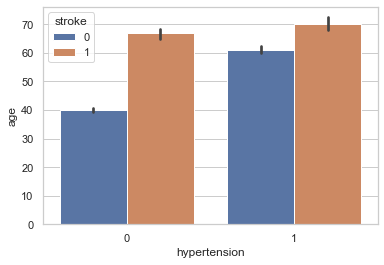

In [234]:
import matplotlib.pyplot as plt


# Initialize the figure with a logarithmic x axis


# Plot the orbital period with horizontal boxes
sns.barplot(x = df['hypertension'], y = df['age'], hue = df['stroke'])

# Add in points to show each observation
#sns.stripplot(x="stroke", y="age", data=df, linewidth=.5)

# Tweak the visual presentation


In [232]:
df.head()

,id,gender,age,hypertension,heartDisease,everMarried,workType,residenceType,avgGlucoseLevel,bmi,smokingStatus,stroke
0,9046,0,67.0,0,1,1,Private,0,228.69,36.600000,formerly smoked,1
1,51676,1,61.0,0,0,1,Self-employed,1,202.21,28.893237,never smoked,1
2,31112,0,80.0,0,1,1,Private,1,105.92,32.500000,never smoked,1
3,60182,1,49.0,0,0,1,Private,0,171.23,34.400000,smokes,1
4,1665,1,79.0,1,0,1,Self-employed,1,174.12,24.000000,never smoked,1


In [220]:
df.describe()

,id,age,hypertension,heartDisease,everMarried,residenceType,avgGlucoseLevel,bmi,stroke
count,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000
mean,36513.985516,43.229986,0.097475,0.054022,0.656293,0.491877,106.140399,28.894508,0.048738
std,21162.008804,22.613575,0.296633,0.226084,0.474991,0.499983,45.285004,7.698235,0.215340
min,67.000000,0.080000,0.000000,0.000000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17740.000000,25.000000,0.000000,0.000000,0.000000,0.000000,77.240000,23.800000,0.000000
50%,36922.000000,45.000000,0.000000,0.000000,1.000000,0.000000,91.880000,28.400000,0.000000
75%,54643.000000,61.000000,0.000000,0.000000,1.000000,1.000000,114.090000,32.800000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,1.000000,1.000000,271.740000,97.600000,1.000000


After playing around with the features for a while, I've settled on this for the moment. This seems to be the sweet spot in the overall accuracy of my model. Though it wasn't the highest percentile score I was able to acheive, it has the msot minimal false negative predicitons. In the case of predicting someone health and the amount of medical attention, it's better to over predicit if someone needs help than to underpredict it.

This model will essentially:
 - Predict 74.8% if a patient will or will not be at risk of heart correctly.
 - Only a minimal Aprox. 2.1% of patients predicted to be 'not at risk' will be misdiagnosed
 - Model has been made to air on the side of caution and over predict risk as opposed to underpredict.

The use case I see this model being most useful for is for family phasicians and general practitioners having a way knowing if the patients they receive are at risk of a stroke being onset later in life. This model can be used for a new patient or garnering a list of current patients inorder to service them better. Calls can be made on behalf of the practitioners to inform patients that they may be at risk and a check up/consultation may be in benefitial.